# A Simple Example of Reinforcement Learning
We will show a few different kinds of reinforcement learning via "the cartpole problem." Through this notebook, you should learn...
- [ ] The basics of OpenAI gym environments
- [ ] How to evaluate a policy on an environment
- [ ] How to train a new policy using policy gradient

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from gym.envs.classic_control import CartPoleEnv
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np

Configuration

In [2]:
training_cycles = 1024

## Create the Environment
The first ingredient is a definition of our environment: balancing a pole on top of the cart.

![image.png](https://www.cs.swarthmore.edu/~mitchell/classes/cs63/f20/labs/07/cartpole.png)

Here, the state of the system can be defined by the position and velocity of the cart and pole.

The action space is a single choice: whether to push the cart to the left or right.

Rewards are 1 if the pole is still balanced atop the cart.

This environment is already build using [OpenAI Gym](https://gym.openai.com/docs/), a library which provides a standard interface for defining environments. The notebooks in this module will show how it can be used for simple environments (like the cart pole) and defining how to build molecules.

Here, we show how to create the environment and how the Cart-Pole environment defines a state space.

In [3]:
env = CartPoleEnv()
print(env.__doc__)


    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.

    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson

    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf

    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right

        Note: The amount the velocity that is reduced

The environment provides us a few useful operations, such as resetting it to an initial position

In [4]:
env.reset()

array([-0.0282977 , -0.00512085, -0.02864437, -0.04449363])

Note how it produces a new set of positions and velocities for the cart-pole system, which we can retrieve at any points by calling `env.state`

In [5]:
env.state

array([-0.0282977 , -0.00512085, -0.02864437, -0.04449363])

We can also access descriptions of the state and action space

In [6]:
print(f'Action space: {env.action_space}')

Action space: Discrete(2)


In [7]:
print(f'State space: {env.observation_space}')

State space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


that can be used to create agents (see next section!) that can automatically work with any kind of environment (as in [TF Agents](https://www.tensorflow.org/agents)).

Another main feature of environments that we will interact with is the `.step(action)` function, which updates the state of the system based on a chosen action

In [8]:
new_state, reward, done, data = env.step(0)

In [9]:
print(f'Its returns the new state of the system: {new_state}')
print(f'A reward that is 1 as long as the poll is balanced: {reward}')

Its returns the new state of the system: [-0.02840011 -0.19982059 -0.02953424  0.23901588]
A reward that is 1 as long as the poll is balanced: 1.0


Let's run the environment from start to finish to demonstrate.

In [10]:
states = []
rewards = []

# Reset the system
env.reset()
done = False

# Step until "done" flag is thrown
while not done:
    new_state, reward, done, data = env.step(0)  # Just push it to one side as an example
    states.append(new_state)
    rewards.append(reward)
    
states = pd.DataFrame(states, columns=['cart_position', 'cart_velocity', 'pole_angle', 'pole_velocity'])
states['reward'] = rewards
states['step'] = np.arange(len(states))

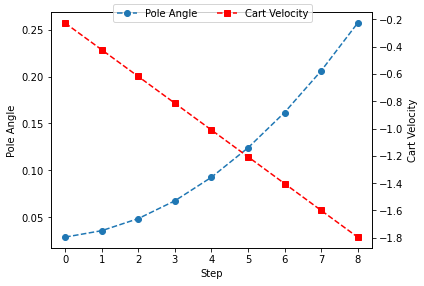

In [11]:
fig, ax = plt.subplots()

ax.plot(states['step'], states['pole_angle'], 'o--', label='Pole Angle')

ax2 = ax.twinx()
ax2.plot(states['step'], states['cart_velocity'], 's--', color='red', label='Cart Velocity')

ax.set_xlabel('Step')
ax.set_ylabel('Pole Angle')
ax2.set_ylabel('Cart Velocity')

fig.legend(loc='upper center', ncol=2)
fig.tight_layout()

We can see that the pole falls quickly with this policy as the cart rapidly accelerates to the left

## Making an "Agent"
In RL terminology, an Agent provides a policy for interacting with an environment and - in most cases - a way to learn how to improve the policy.

Practically, agents must generate a action based on the state of a system. Let's start with one that pushes the cart to left if the pole is leaning that way. 

In [12]:
class Agent:
    """Base class for an agent. 
    
    Defines the operations needed to use and train the agent.
    """
    
    def get_action(self, state):
        """Generate an action given the state of the system"""
        raise NotImplementedError()
    
    def train(self, states):
        """Update an agent's policies given some examples of states"""
        raise NotImplementedError()

In [13]:
class SimpleAgent:
    """An agent that reacts to the position of a pole with a simple policy: Push the cart to make the pole stand upright"""
    
    def get_action(self, state):
        """Generate an action given the state of the system"""
        
        # Get the pole angle
        pole_angle = state[2]
        
        # Return an action that pushes the cart under the pole
        return 0 if pole_angle < 0 else 1
    
    def train(self, states):
        return

In [14]:
agent = SimpleAgent()

Now, let's simulate this policy

In [15]:
def enact_policy(env, agent):
    """Run a policy on an environment given an agent"""
    states = []
    rewards = []
    actions = []

    # Reset the system
    state = env.reset()
    done = False

    # Step until "done" flag is thrown
    while not done:
        action = agent.get_action(state)
        state, reward, done, data = env.step(action)  # Just push it to one side as an example
        states.append(state)
        rewards.append(reward)
        actions.append(action)

    states = pd.DataFrame(states, columns=['cart_position', 'cart_velocity', 'pole_angle', 'pole_velocity'])
    states['reward'] = rewards
    states['step'] = np.arange(len(states))
    states['action'] = actions
    return states

In [16]:
states = enact_policy(env, agent)

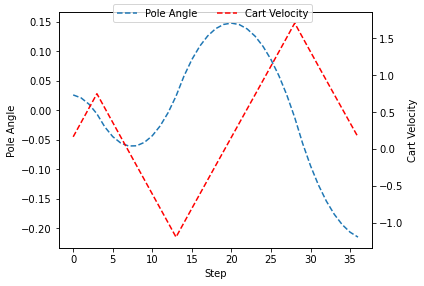

In [17]:
fig, ax = plt.subplots()

ax.plot(states['step'], states['pole_angle'], '--', label='Pole Angle')

ax2 = ax.twinx()
ax2.plot(states['step'], states['cart_velocity'], '--', color='red', label='Cart Velocity')

ax.set_xlabel('Step')
ax.set_ylabel('Pole Angle')
ax2.set_ylabel('Cart Velocity')

fig.legend(loc='upper center', ncol=2)
fig.tight_layout()

Ok, it looks better. Our pole waves back and forth with greater amplitude until it crashes. Not ideal, but a better policy.

Let's see how it does over many examples of the policy compared to a "random baseline".

In [18]:
class RandomAgent(Agent):
    """Pick an action randomly"""
    
    def get_action(self, state):
        return np.random.randint(0, 1)
    
    def train(self, states):
        return 

In [19]:
def evaluate_agent(env, agent, n_episodes, train=True):
    """Evalaute an agent over many episodes of the cart-pole game
    
    Args:
        env: Test environment
        agent: Agent to use and train
        n_episodes: Number of episodes to run with the game
        train: Whether to train the agent after each episode
    Returns:
        Dataframe with the results of each episode
    """
    
    # Storage for the length of each episode
    length = []
    
    # Run the desired number of episodes
    for i in tqdm(range(n_episodes), leave=False):
        # Run the environment
        states = enact_policy(env, agent)
        length.append(len(states))
        
        # Update agent, if desired
        if train:
            agent.train(states)
        
    # Make the output
    return pd.DataFrame({'length': length, 'episode': np.arange(n_episodes)})

In [20]:
random_results = evaluate_agent(env, RandomAgent(), 256)
simple_results = evaluate_agent(env, SimpleAgent(), 256)

Text(0.5, 0, 'Episode Length')

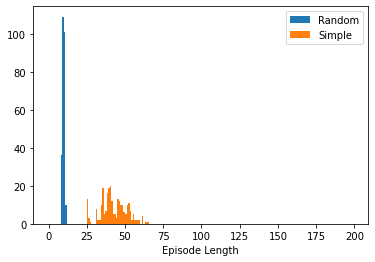

In [21]:
fig, ax = plt.subplots()

bins = np.arange(200)
ax.hist(random_results['length'], bins=bins, label='Random')
ax.hist(simple_results['length'], bins=bins, label='Simple')

ax.legend()
ax.set_xlabel('Episode Length')

The simple agent does better than random, but we are still far from acheiving the 200-length episodes for "winning" the cart-pole challenge.

## Learning a Policy: Policy Gradient / `REINFORCE` Algorithm
Let's now move in to trying to use reinforcement learning to learn a better agent, starting with a simple technique: `REINFORCE`. See an excellent [blog post from Chris Yoon](https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63) for the derivation and example code that we copied for this exercise.

### Step 1: Create a policy function

Policy gradient methods always have an policy function (known as an actor) that produces a probability distribution for possible actions given a state: $\pi_{\theta}(a|s) = P(a|s)$

Our our case, let's make a probablistic version of the `SimpleAgent` we define earlier by making the probability of choosing to push left or right dependant on the angle of pole:

$P(a=1|s) = \frac{1}{1+\exp(-\theta s_{angle})}$

where $s_{angle}$ is the angle of the pole and $\theta$ is a parameter to be learned by the data.
We can express this as a simple neural network with a logistic layer that has no bias

In [22]:
model = Sequential([Dense(1, use_bias=False, activation='sigmoid', input_shape=(1,))])

Evaluate the policy for the possible range of angles

In [23]:
s_angle = np.linspace(-0.418, 0.418, 128)[:, None]
prob_left = model.predict(s_angle)

Text(0, 0.5, 'P(a=0)')

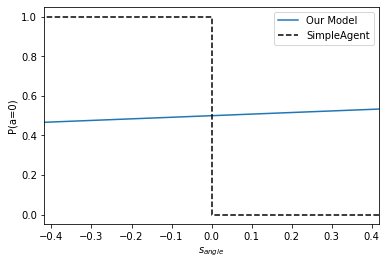

In [24]:
fig, ax = plt.subplots()

ax.plot(s_angle, prob_left, label='Our Model')
ax.step([-1, 0, 1], [1, 1, 0], 'k--', label='SimpleAgent')

ax.set_xlim(s_angle.min(), s_angle.max())
ax.legend()
ax.set_xlabel('$s_{angle}$')
ax.set_ylabel('P(a=0)')

We now have a policy function that produces a probability depending on angle! 

### Step 2: Making training data
Our next step is to run an episode with this agent to see how it does. 

We first make an agent class that uses this model

In [25]:
class AngleOnlyPGAgent(Agent):
    """A policy-gradient-trained agent that uses only the pole angle to predict an action"""
    
    def __init__(self):
        # Define our model
        self.actor = Sequential([Dense(1, use_bias=False, activation='sigmoid', input_shape=(1,))])
    
    def get_action(self, state):
        # Get the pole angle
        pole_angle = state[2]
        
        # Compute the probability of left
        p_left = self.actor.predict(np.atleast_2d(pole_angle))
    
        # Choose action randomly
        return 0 if np.random.random() < p_left else 1
    
    def train(self, states):
        # Not yet!
        pass

In [26]:
agent = AngleOnlyPGAgent()

Run the policy

In [27]:
states = enact_policy(env, agent)

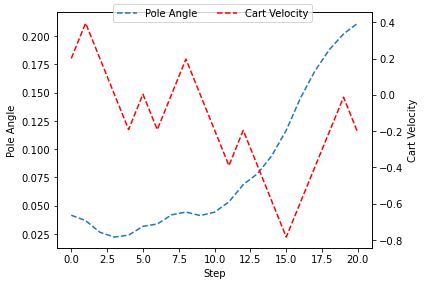

In [28]:
fig, ax = plt.subplots()

ax.plot(states['step'], states['pole_angle'], '--', label='Pole Angle')

ax2 = ax.twinx()
ax2.plot(states['step'], states['cart_velocity'], '--', color='red', label='Cart Velocity')

ax.set_xlabel('Step')
ax.set_ylabel('Pole Angle')
ax2.set_ylabel('Cart Velocity')

fig.legend(loc='upper center', ncol=2)
fig.tight_layout()

Ok, we now have some data on how the model behaved

### Step 3: Updating the Model with Policy Gradient
The key equation behind `REINFORCE`-style policy gradient is a equation that determines how to update the parameters given observed behavior:

$\theta\gets\theta + \alpha V^*_t\nabla_\theta\log\pi(a_t,s_t)$

we have observations of the actions taken ($a_t$) and the state of the system ($s_t$) at each step.

$V^*_t$ is a based on the rewards gathered for certain steps in the future ($V_t=\sum_{i=0}^n\gamma^ir_{t+1}$) normalized by the average reward for all steps ($V^*_t=V_t-𝔼[V_t]$)

Breaking the math apart aside, what this does is compute the gradient of the probability of action given parameters ($\nabla_\theta\log\pi(a_t,s_t)$) and steps in that direction if the value of the move ($V^*_t$) is better than average (making the probability more likely). $\alpha$ is just a parameter that controls how quickly we update weights

Let's do one step of that with our models

In [29]:
# Configuration parameters for the lookahead
n_lookahead = 16
gamma = 0.9

# Compute the V for each step
vs = []
for t in range(len(states)):
    # Get the rewards rewards ahead of that state
    future_rewards = states['reward'][t:(t+n_lookahead)].values
    
    # Sum them with the discount factor
    v = 0
    for i in range(len(future_rewards)):
        v += gamma ** i * future_rewards[i]
    vs.append(v)
    
states['values'] = vs

Text(0, 0.5, 'Rewards')

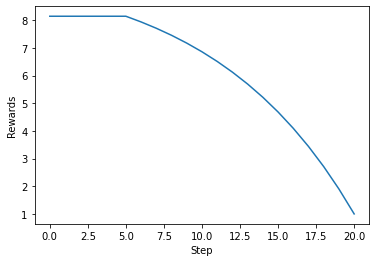

In [30]:
fig, ax = plt.subplots()

ax.plot(states['values'])

ax.set_xlabel('Step')
ax.set_ylabel('Rewards')

The reward drops off towards the end because there is not as many future rewards to collect.

Now to use it to update the parameter for the model. Getting the normalized value ($V^*_t$) is easy

In [31]:
# Get the normed value for each state
states['values_normed'] = states['values'] - states['values'].mean()

Gradients are a little trickier. We are going to use Tensorflow to compute them, which we do by using [a gradient tape](https://www.tensorflow.org/guide/autodiff) to keep track of the computations that will be used when computing gradients

In [32]:
with tf.GradientTape() as tape:
    # Get the probability of pushing left
    #  The [:, np.newaxis] turns the array from shape (N) to (N, 1)
    #  which is needed because keras expects 2D inputs
    prob_left = agent.actor(states['pole_angle'].values)
    
    # Get the log probability of picking our certain choice
    #  We use "where" to pick "prob_left" when the action was 1 and 
    #  1 - prob otherwise
    prob = tf.where(states['action'].values == 0, prob_left[:, 0], 1 - prob_left[:, 0])
    
    # Get the log probability
    log_prob = tf.math.log(prob)
    
    # Multiply it by the value of the action
    log_prob_x_value = log_prob * states['values_normed']
    
    # Average over the gradients of each training point
    #  Ensures that our measurements of the gradients are less noisy
    loss = tf.reduce_mean(log_prob_x_value)

We can then use the tape to get gradient wrt the variables of the models

In [33]:
grads = tape.gradient(loss, agent.actor.variables)
print('Gradients of each parameter:')
grads

Gradients of each parameter:


[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.02091252]], dtype=float32)>]

We then update the parameters given the new gradients. $\alpha$ controls how much we change them

In [34]:
alpha = 1000  # Large value for demonstration purposes
new_theta = [x + alpha * y for x, y in zip(agent.actor.variables, grads)]
print('New parameters:')
new_theta

New parameters:


[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[21.104906]], dtype=float32)>]

In [35]:
old_theta = agent.actor.get_weights()
old_prob_left = agent.actor.predict(s_angle)
agent.actor.set_weights(new_theta)
new_prob_left = agent.actor.predict(s_angle)

Plotting the new versus old

Text(0, 0.5, 'P(a=0)')

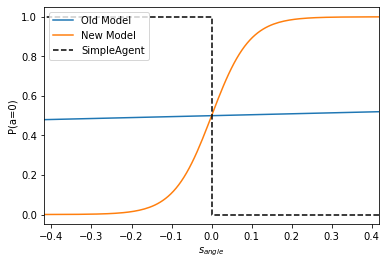

In [36]:
fig, ax = plt.subplots()


ax.plot(s_angle, old_prob_left, label='Old Model')
ax.plot(s_angle, new_prob_left, label='New Model')
ax.step([-1, 0, 1], [1, 1, 0], 'k--', label='SimpleAgent')

ax.set_xlim(s_angle.min(), s_angle.max())
ax.legend()
ax.set_xlabel('$s_{angle}$')
ax.set_ylabel('P(a=0)')

The parameters are updated. It may or may not be better than the original choice for $\theta$, depending on the training data that was used for this particular step. We will only be able to learn a converged policy by continually training over many iterations of the game.

### Step 4: Training Model over Many Generations

Let's now add our model training code to the agent so we can train it more easily

In [37]:
class AngleOnlyPGAgent(Agent):
    """A policy-gradient-trained agent that uses only the pole angle to predict an action"""
    
    def __init__(self, alpha=10, n_lookahead=16, gamma=0.9):
        """
        Args:
            alpha: Learning rate
            n_lookahead: Number of steps to lookahead when computing the reward
            gamma: Discount rate for future rewards
        """
        self.alpha = alpha
        self.n_lookahead = n_lookahead
        self.gamma = gamma
        self.actor = Sequential([Dense(1, use_bias=False, activation='sigmoid', input_shape=(1,))])
        self.thetas = []  # Store the parameter values
    
    def get_action(self, state):
        # Get the pole angle
        pole_angle = state[2]
        
        # Compute the probability of left
        p_left = self.actor.predict(np.atleast_2d(state[2]))
        
        # Choose action randomly
        return 0 if np.random.random() < p_left else 1
    
    def compute_rewards(self, states):
        """Compute the reward for each step in an episode
        
        Args:
            states: Data for a single episode, will be updated with new columns
        """
        
        # Compute the V for each step
        vs = []
        for t in range(len(states)):
            # Get the rewards rewards ahead of that state
            future_rewards = states['reward'][t:(t+self.n_lookahead)].values

            # Sum them with the discount factor
            v = 0
            for i in range(len(future_rewards)):
                v += self.gamma ** i * future_rewards[i]
            vs.append(v)

        # Set them in the DataFrame
        states['values'] = vs
        
        # Get the normed value for each state
        states['values_normed'] = (states['values'] - states['values'].mean()) / states['values'].std()
    
    def train(self, states):
        # Get the values for each states
        self.compute_rewards(states)
        
        with tf.GradientTape() as tape:
            # Get the probability of pushing left
            #  The [:, np.newaxis] turns the array from shape (N) to (N, 1)
            #  which is needed because keras expects 2D inputs
            prob_left = self.actor(states['pole_angle'].values)

            # Get the log probability of picking our certain choice
            #  We use "where" to pick "prob_left" when the action was 0 and 
            #  1 - prob_left otherwise
            prob = tf.where(states['action'].values == 0, prob_left[:, 0], 1 - prob_left[:, 0])

            # Get the log probability
            log_prob = tf.math.log(prob)

            # Multiply it by the value of the action
            log_prob_x_value = log_prob * states['values_normed']

            # Average over the gradients of each training point
            #  Ensures that our measurements of the gradients are less noisy
            loss = tf.reduce_mean(log_prob_x_value)
            
        # Compute the gradients
        grads = tape.gradient(loss, self.actor.variables)
        
        # Update the parameters given the gradients
        new_theta = [x + self.alpha * y for x, y in zip(self.actor.variables, grads)]
        agent.actor.set_weights(new_theta)
        
        # Store the new value
        self.thetas.append(np.squeeze(new_theta[0]))

Train it over many episodes (takes about a half hour, so get comfortable!)

In [38]:
agent = AngleOnlyPGAgent()

In [39]:
angleonly_results = evaluate_agent(env, agent, training_cycles)

We can see that the $\theta$ value gradually changes over time as the model trains

Text(0, 0.5, '$\\theta$')

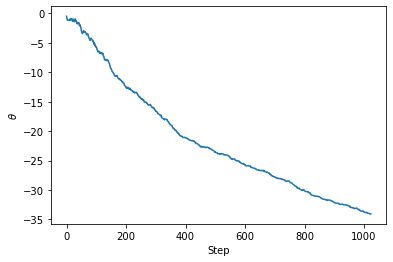

In [40]:
fig, ax = plt.subplots()

ax.plot(agent.thetas)
ax.set_xlabel('Step')
ax.set_ylabel('$\\theta$')

As that happens, the agent is managing to keep the poll balanced for longer. The red line is the average over the last 32 episodes, which are shown in gray.

Text(0, 0.5, 'Episode Length')

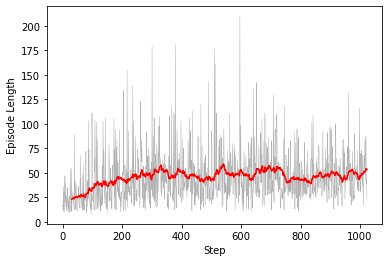

In [41]:
fig, ax = plt.subplots()

ax.plot(angleonly_results['length'], 'k', lw=0.5, alpha=0.3)
ax.plot(angleonly_results['length'].rolling(32).mean(), 'r')

ax.set_xlabel('Step')
ax.set_ylabel('Episode Length')

By the end, we converge to a policy that is similar to our "SimpleAgent." We push left with greater probability when the pole is tilted left. When the pole is closer to upright, we randomly push from the opposite direction more often so that we do not overcorrect and get those undamped oscillations shown with the simple agent.

Text(0, 0.5, 'P(a=0)')

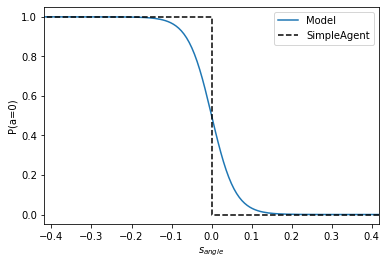

In [42]:
fig, ax = plt.subplots()

prob_left = agent.actor.predict(s_angle)
ax.plot(s_angle, prob_left, label='Model')
ax.step([-1, 0, 1], [1, 1, 0], 'k--', label='SimpleAgent')

ax.set_xlim(s_angle.min(), s_angle.max())
ax.legend()
ax.set_xlabel('$s_{angle}$')
ax.set_ylabel('P(a=0)')

In [43]:
states = enact_policy(env, agent)

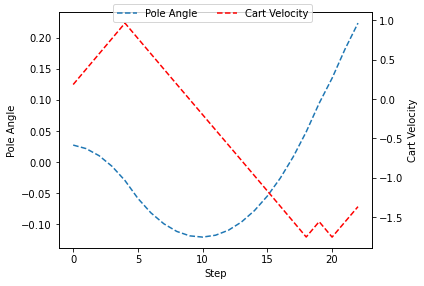

In [44]:
fig, ax = plt.subplots()


ax.plot(states['step'], states['pole_angle'], '--', label='Pole Angle')

ax2 = ax.twinx()
ax2.plot(states['step'], states['cart_velocity'], '--', color='red', label='Cart Velocity')

ax.set_xlabel('Step')
ax.set_ylabel('Pole Angle')
ax2.set_ylabel('Cart Velocity')

fig.legend(loc='upper center', ncol=2)
fig.tight_layout()

If we look at the last 256 cycles, we see that our new agent outperforms the simple policy. Some of the episodes are able to last over 100 steps before the pole falls.

Text(0.5, 0, 'Episode Length')

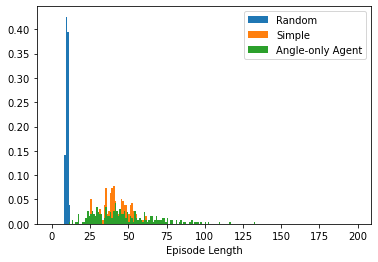

In [45]:
fig, ax = plt.subplots()

bins = np.arange(200)
ax.hist(random_results['length'], bins=bins, density=True, label='Random')
ax.hist(simple_results['length'], bins=bins, density=True, label='Simple')

# Plot only the last 128 iterations for the pG 
ax.hist(angleonly_results['length'].tail(256), bins=bins, density=True, label='Angle-only Agent')

ax.legend()
ax.set_xlabel('Episode Length')

### Step 5: Building a Full Agent
We are going to use a network now that thaakes the full state of the system into account and uses a sophisticated optimizer ([Adam](https://keras.io/api/optimizers/adam/)) rather than just gradient descent.

In [46]:
class PGAgent(Agent):
    """A policy-gradient-trained agent that uses only the pole angle to predict an action"""
    
    def __init__(self, n_lookahead=16, gamma=0.9):
        """
        Args:
            n_lookahead: Number of steps to lookahead when computing the reward
            gamma: Discount rate for future rewards
        """
        self.alpha = alpha
        self.n_lookahead = n_lookahead
        self.gamma = gamma
        self.actor = Sequential([
            Dense(128, use_bias=True, activation='relu', input_shape=(4,)),
            Dense(1, use_bias=False, activation='sigmoid')
        ])
        self.opt = Adam()
    
    def get_action(self, state):       
        # Compute the probability of left
        p_left = self.actor.predict(state[np.newaxis, :])
        
        # Choose action randomly
        return 0 if np.random.random() < p_left else 1
    
    def compute_rewards(self, states):
        """Compute the reward for each step in an episode
        
        Args:
            states: Data for a single episode, will be updated with new columns
        """
        
        # Compute the V for each step
        vs = []
        for t in range(len(states)):
            # Get the rewards rewards ahead of that state
            future_rewards = states['reward'][t:(t+self.n_lookahead)].values

            # Sum them with the discount factor
            v = 0
            for i in range(len(future_rewards)):
                v += self.gamma ** i * future_rewards[i]
            vs.append(v)

        # Set them in the DataFrame
        states['values'] = vs
        
        # Get the normed value for each state
        states['values_normed'] = (states['values'] - states['values'].mean()) / states['values'].std()
    
    def train(self, states):
        # Get the values for each states
        self.compute_rewards(states)
        
        with tf.GradientTape() as tape:
            # Get the probability of pushing left
            #  The states has a reward
            prob_left = self.actor(states[['cart_position', 'cart_velocity', 'pole_angle', 'pole_velocity']].values)

            # Get the log probability of picking our certain choice
            #  We use "where" to pick "prob_left" when the action was 1 and 
            #  1 - prob otherwise
            prob = tf.where(states['action'].values == 0, prob_left[:, 0], 1 - prob_left[:, 0])

            # Get the log probability
            log_prob = tf.math.log(prob)

            # Multiply it by the value of the action
            log_prob_x_value = log_prob * states['values_normed']

            # Average over the gradients of each training point
            #  Ensures that our measurements of the gradients are less noisy
            #  We multiply by -1 because Adam tries to minimize the loss
            loss = -1 * tf.reduce_mean(log_prob_x_value)  
            
        # Compute the gradients
        grads = tape.gradient(loss, self.actor.variables)
        
        # Update the parameters given the gradients
        self.opt.apply_gradients(zip(grads, self.actor.variables))

In [47]:
pgagent = PGAgent()

This training takes around 1 hour

In [48]:
pgagent_results = evaluate_agent(env, pgagent, training_cycles)

Plot the performance over time

Text(0, 0.5, 'Episode Length')

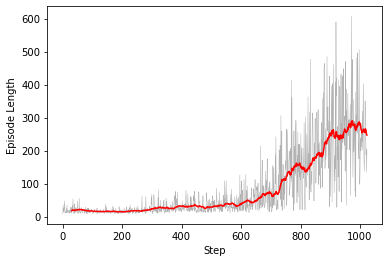

In [49]:
fig, ax = plt.subplots()

ax.plot(pgagent_results['length'], 'k', lw=0.5, alpha=0.3)
ax.plot(pgagent_results['length'].rolling(32).mean(), 'r')

ax.set_xlabel('Step')
ax.set_ylabel('Episode Length')

Plot it on a sample trajectory

In [50]:
states = enact_policy(env, pgagent)

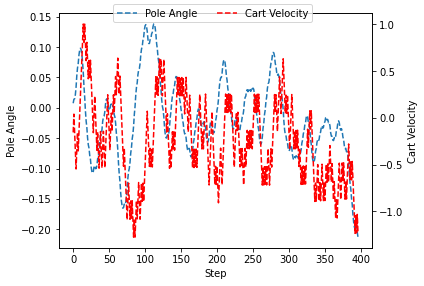

In [51]:
fig, ax = plt.subplots()


ax.plot(states['step'], states['pole_angle'], '--', label='Pole Angle')

ax2 = ax.twinx()
ax2.plot(states['step'], states['cart_velocity'], '--', color='red', label='Cart Velocity')

ax.set_xlabel('Step')
ax.set_ylabel('Pole Angle')
ax2.set_ylabel('Cart Velocity')

fig.legend(loc='upper center', ncol=2)
fig.tight_layout()

Compare to the other approaches

Text(0.5, 0, 'Episode Length')

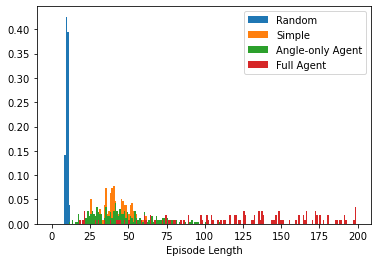

In [52]:
fig, ax = plt.subplots()

bins = np.arange(200)
ax.hist(random_results['length'], bins=bins, density=True, label='Random')
ax.hist(simple_results['length'], bins=bins, density=True, label='Simple')

# Plot only the last 256 iterations for
ax.hist(angleonly_results['length'].tail(256), bins=bins, density=True, label='Angle-only Agent')
ax.hist(pgagent_results['length'].tail(256), bins=bins, density=True, label='Full Agent')

ax.legend()
ax.set_xlabel('Episode Length')

By the end of the training, this full agent does much better than any of the other methods we have tried before!

You should now know:

- [x] The basics of OpenAI gym environments: *They provide a state and rewards/a new state when you apply an action to it*
- [x] How to evaluate a policy on an environment: *Build an agent that produces an action given state*
- [x] How to train a new policy using policy gradient: *Update the policy adjusting weights such that they improve the likelihood of "good" moves